In [ ]:
import pandas as pd
import numpy as np
import json
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

%matplotlib inline

Please set the variable `path_logs` to the path where you want to access the .logs files to be converted to .json files and saved into the project `logs` directory 

In [5]:
logs_folder = '/Users/igorlimarochaazevedo/Documents/Cellcrypt/logsSeafile/'

In [7]:
logs_seafile = [dI for dI in os.listdir(logs_folder) if os.path.isdir(os.path.join(logs_folder,dI))]
print(logs_seafile)

['Sep 10th', 'Sep 14th', 'Sep 8th', 'Sep11th', 'Sep 9th']


In [9]:
dst = './logs'
def copyFiles(src, dst):
    src_files = os.listdir(src)
    for file_name in src_files:
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst)
            
for i in logs_seafile:
    copyFiles(logs_folder + i, dst)

In [10]:
def generateJsonFromLog(folder_path):
    ''' This method is responsible for converting .log files to .json files. Since
    python libraries work better with json files. '''
    files = []
    for r, d, f in os.walk(folder_path):
        for file in f:
            if '.log' in file:
                files.append(os.path.join(r, file))
    
    for f in files:
        pre, ext = os.path.splitext(f)
        os.rename(f, pre + '.json')
generateJsonFromLog(dst)

In [11]:
def deleteFilesEqualNames(src):
    '''This method is used to remove duplicates files in the format such as callstats_XXXX_XXXX \(1\).log
    because they are duplicates files.'''
    files = []
    file_name = ''
    for r, d, f in os.walk(src):
        for file in f:
            for k in file.split():
                if "(1).json" == k:
                    os.remove(src + '/' + file_name + ' ' + k)
                file_name = k
deleteFilesEqualNames(dst)

In [14]:
def returnListJSON(folder_path):
    '''This method returns an array of all .json files inside of the logs folder.'''
    files = []
    for r, d, f in os.walk(folder_path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    return files
list_logs = returnListJSON("./logs")

In [15]:
def getLogDF(list_logs):
    '''Returns a dataframe containing all the informations except from call's parameters.
    Informations such as alias, IP, status, rating, etc.'''
    df = pd.DataFrame()
    frames = []
    
    for i in range(len(list_logs)):
        with open(list_logs[i]) as f:
            file_json = json.load(f)
            df = pd.json_normalize(file_json)
            df = df.drop(['data'], axis=1)
            df = df.drop_duplicates()
            frames.append(df)

    df = pd.concat(frames)
    df = df.reset_index()
    
    return df
df_log = getLogDF(list_logs)
print(df_log.shape)
df_log.head()

(175, 15)


index                        alias                          peer  type  \
0      0      harvey+andfed@csghq.com   rogerio.richa@cellcrypt.com     1   
1      0   vitor.monticelli@csghq.com  ricardo.heffel+win@csghq.com     1   
2      0   vitor.monticelli@csghq.com          auto.alice@csghq.com     1   
3      0  rogerio.richa@cellcrypt.com       harvey+andfed@csghq.com     1   
4      0  rogerio.richa@cellcrypt.com       william.nunes@csghq.com     1   

                   version                       call_id  client  \
0  101-3.131.0.3131000-FED   rogerio.richa@cellcrypt.com       0   
1  101-3.131.0.3131000-FED  ricardo.heffel+win@csghq.com       0   
2  101-3.131.0.3131000-FED          auto.alice@csghq.com       0   
3  101-3.131.0.3131000-FED       harvey+andfed@csghq.com       0   
4                  3.132.0       william.nunes@csghq.com       0   

          address   timestamp  duration  status media_relay  rating  issue  \
0  197.188.173.89           0         0      11         NaN     NaN    NaN   
1   191.191.46.59  1599680922       189       7         NaN     NaN    NaN   
2   191.191.46.59           0         0      11         NaN     NaN    NaN   
3     189.4.81.95           0         0      11         NaN     NaN    NaN   
4  177.25.243.114  1599858182       329       7         NaN     NaN    NaN   

  comment  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [16]:
def genCallParametersDF(list_logs):
    '''This method generates a single dataframe with all the call's informations
    obtained from every .json file. The general idea here was to unify all variables 
    in a single dataframe and appeding to it an alias and a timestamp. This way, 
    it is possible to unique identify every column in the dataframe.'''
    data = {'time': [], 
            'latency': [], 
            'jitter_rx': [],
            'jitter_tx': [],
            'packet_loss_rx': [],
            'packet_loss_tx': [],
            'alias': [],
            'call_id':[],} 
    df = pd.DataFrame(data)
    frames = []
    for i in range(len(list_logs)):
        with open(list_logs[i]) as f:
            file_json = json.load(f)
            df_json = pd.json_normalize(file_json['data'])
            df_json['alias'] = file_json['alias']
            df_json['timestamp'] = file_json['timestamp']
            df_json['status'] = file_json['status']
            if 'call_id' in file_json:
                df_json['call_id'] = file_json['call_id']
            else:
                df_json['call_id'] = np.nan
            frames.append(df_json)

    df = pd.concat(frames)
    df = df.reset_index()
    
    return df

df_call_parameters = genCallParametersDF(list_logs)
print(df_call_parameters.shape)
df_call_parameters.head(15)

(45893, 11)


index                       alias   timestamp  status  \
0       0  vitor.monticelli@csghq.com  1599680922       7   
1       1  vitor.monticelli@csghq.com  1599680922       7   
2       2  vitor.monticelli@csghq.com  1599680922       7   
3       3  vitor.monticelli@csghq.com  1599680922       7   
4       4  vitor.monticelli@csghq.com  1599680922       7   
5       5  vitor.monticelli@csghq.com  1599680922       7   
6       6  vitor.monticelli@csghq.com  1599680922       7   
7       7  vitor.monticelli@csghq.com  1599680922       7   
8       8  vitor.monticelli@csghq.com  1599680922       7   
9       9  vitor.monticelli@csghq.com  1599680922       7   
10     10  vitor.monticelli@csghq.com  1599680922       7   
11     11  vitor.monticelli@csghq.com  1599680922       7   
12     12  vitor.monticelli@csghq.com  1599680922       7   
13     13  vitor.monticelli@csghq.com  1599680922       7   
14     14  vitor.monticelli@csghq.com  1599680922       7   

                         call_id  time  latency  jitter_rx  jitter_tx  \
0   ricardo.heffel+win@csghq.com   0.0      0.0        0.0        0.0   
1   ricardo.heffel+win@csghq.com   1.0      0.0        0.0        0.0   
2   ricardo.heffel+win@csghq.com   2.0      0.0        0.0        0.0   
3   ricardo.heffel+win@csghq.com   3.0      0.0       17.0        0.0   
4   ricardo.heffel+win@csghq.com   4.0      0.0       18.0        0.0   
5   ricardo.heffel+win@csghq.com   5.0     38.0       17.0        7.0   
6   ricardo.heffel+win@csghq.com   6.0     38.0       17.0        7.0   
7   ricardo.heffel+win@csghq.com   7.0     38.0       18.0        7.0   
8   ricardo.heffel+win@csghq.com   8.0     38.0       16.0        7.0   
9   ricardo.heffel+win@csghq.com   9.0     46.0       15.0       10.0   
10  ricardo.heffel+win@csghq.com  10.0     46.0       14.0       10.0   
11  ricardo.heffel+win@csghq.com  11.0     46.0       14.0       10.0   
12  ricardo.heffel+win@csghq.com  12.0     46.0       14.0       10.0   
13  ricardo.heffel+win@csghq.com  13.0     46.0       16.0       10.0   
14  ricardo.heffel+win@csghq.com  14.0     36.0       16.0       12.0   

    packet_loss_rx  packet_loss_tx  
0            100.0             0.0  
1            100.0             0.0  
2              0.0             0.0  
3              6.0             0.0  
4              3.0             0.0  
5              2.0             0.0  
6              1.0             0.0  
7              1.0             0.0  
8              1.0             0.0  
9              1.0             0.0  
10             0.0             0.0  
11             0.0             0.0  
12             0.0             0.0  
13             0.0             0.0  
14             0.0             0.0

In [17]:
df_call_parameters.describe()

index     timestamp       status          time       latency  \
count  45893.000000  4.589300e+04  45893.00000  45893.000000  45893.000000   
mean     616.576166  1.599690e+09      6.98612    616.861155    109.490816   
std      603.252901  1.580341e+05      0.31140    603.318037    114.664404   
min        0.000000  1.599247e+09      0.00000      0.000000      0.000000   
25%      143.000000  1.599577e+09      7.00000    143.000000      0.000000   
50%      391.000000  1.599745e+09      7.00000    391.000000     51.000000   
75%      963.000000  1.599833e+09      7.00000    963.000000    201.000000   
max     2878.000000  1.600077e+09      7.00000   2878.000000    432.000000   

          jitter_rx     jitter_tx  packet_loss_rx  packet_loss_tx  
count  45893.000000  45893.000000    45893.000000    45893.000000  
mean      10.930185     14.110627        1.047022        1.473602  
std        8.242392      4.662176        6.321096        3.114723  
min       -1.000000      0.000000       -1.000000        0.000000  
25%       -1.000000     12.000000       -1.000000        0.000000  
50%       15.000000     14.000000        0.000000        0.000000  
75%       16.000000     18.000000        0.000000        2.000000  
max       34.000000     38.000000      100.000000       50.000000

In [122]:
df_call_status = df_call_parameters.groupby('status').count()
df_call_status.head()

index  alias  timestamp  call_id   time  latency  jitter_rx  \
status                                                                
0          91     91         91       91     91       91         91   
7       45802  45802      45802    45802  45802    45802      45802   

        jitter_tx  packet_loss_rx  packet_loss_tx  
status                                             
0              91              91              91  
7           45802           45802           45802

In [132]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

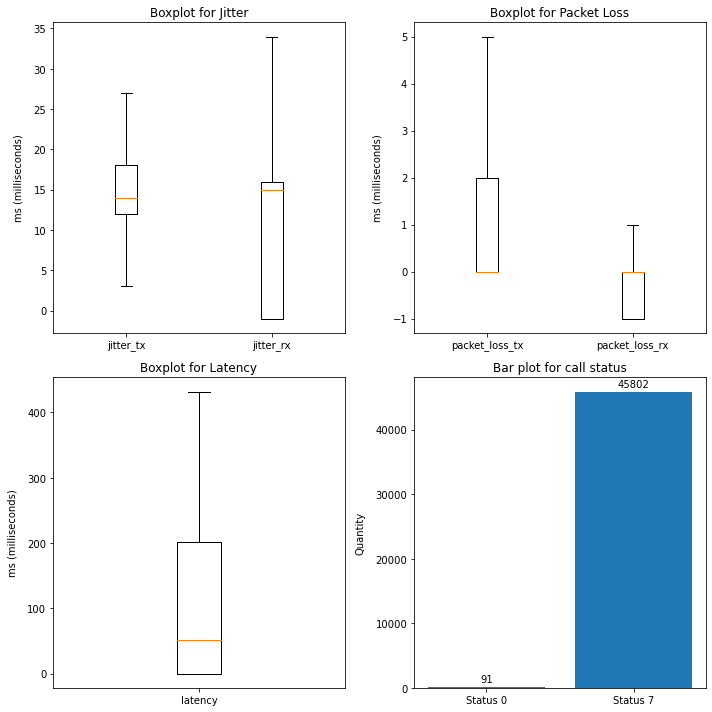

In [193]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

### Jitter
labels_jitter = ['jitter_tx', 'jitter_rx']
axs[0, 0].boxplot([df_call_parameters['jitter_tx'], df_call_parameters['jitter_rx']], 
                             labels=labels_jitter, showfliers=False)
axs[0, 0].set_ylabel('ms (milliseconds)', labelpad=10, fontsize=10)
axs[0, 0].set_title('Boxplot for Jitter', fontsize=12, ha='center')

### Packet Loss
labels_packet_loss = ['packet_loss_tx', 'packet_loss_rx']
axs[0, 1].boxplot([df_call_parameters['packet_loss_tx'], df_call_parameters['packet_loss_rx']], 
                             labels=labels_packet_loss, showfliers=False)
axs[0, 1].set_ylabel('ms (milliseconds)', labelpad=10, fontsize=10)
axs[0, 1].set_title('Boxplot for Packet Loss', fontsize=12, ha='center')

### Latency
label_latency = ['latency']
axs[1, 0].boxplot([df_call_parameters['latency']], 
                             labels=label_latency, showfliers=False)
axs[1, 0].set_ylabel('ms (milliseconds)', labelpad=10, fontsize=10)
axs[1, 0].set_title('Boxplot for Latency', fontsize=12, ha='center')

### Status
labels_status = ['Status 0', 'Status 7']
rects1 = axs[1, 1].bar(labels_status, df_call_status['index'].values)
autolabel(rects1, axs[1, 1])

axs[1, 1].set_ylabel('Quantity', labelpad=10, fontsize=10)
axs[1, 1].set_title('Bar plot for call status', fontsize=12, ha='center')

# plt.legend()
plt.tight_layout()
plt.show()

In [301]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Jitter", "Packet Loss", 
                                                    "Latency", "Status"))


### Jitter
fig.add_trace(go.Box(y=df_call_parameters['jitter_rx'], name="jitter_rx",
                      boxpoints=False, marker_color='rgb(7,40,89)'),
                      row=1, col=1)

fig.add_trace(go.Box(y=df_call_parameters['jitter_tx'], name="jitter_tx",
                     boxpoints=False, marker_color='rgb(107,174,214)'),
                     row=1, col=1)

### Packet Loss
fig.add_trace(go.Box(y=df_call_parameters['packet_loss_rx'], name="packet_loss_rx", 
                     boxpoints=False, marker_color='rgb(7,40,89)'),
                     row=1, col=2)

fig.add_trace(go.Box(y=df_call_parameters['packet_loss_tx'], name="packet_loss_tx", 
                     boxpoints=False, marker_color='rgb(107,174,214)'),
                     row=1, col=2)

### Latency
fig.add_trace(go.Box(y=df_call_parameters['latency'], name="latency", marker_color='rgb(107,174,214)'),
              row=2, col=1)


### Call Status
labels_status = []
for i in df_call_status.index.values:
    labels_status.append('Status ' + str(i))
    
fig.add_trace(go.Bar(y=df_call_status['index'], 
                     x=labels_status,
                     text=df_call_status['index'], 
                     textposition='auto',
                     marker_color='rgb(7,40,89)'),
                     row=2, col=2)

# Update xaxis properties
fig.update_xaxes(title_text="Status code", row=2, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="ms (milliseconds)", row=1, col=1)
fig.update_yaxes(title_text="% (percentage)", row=1, col=2)
fig.update_yaxes(title_text="ms (milliseconds)", showgrid=False, row=2, col=1)
fig.update_yaxes(title_text="Quantity", row=2, col=2)

fig.update_yaxes(automargin=True)
fig.update_layout(height=800, width=1000, title_text="General Info about the logs")
fig.show()
